# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set

In [2]:
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = np.shape(X_test[0])

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

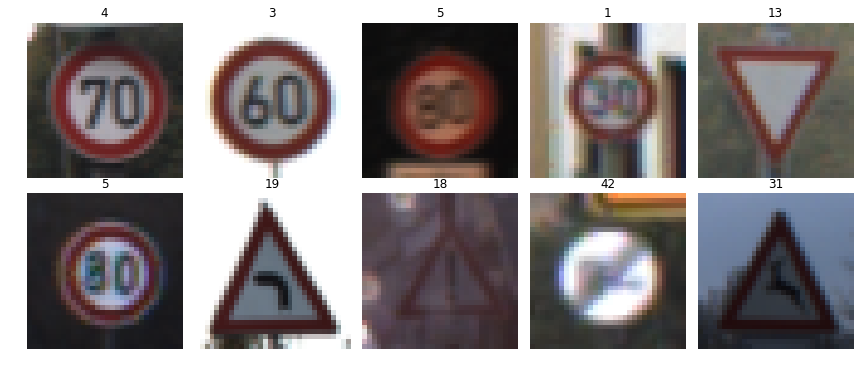

In [3]:
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

# show 10 images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = 0.1, wspace=0.01)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

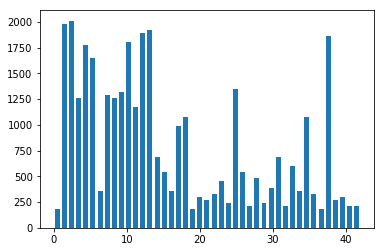

In [4]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Data Augmentation

To augment the data first a set of functions are created that will rotate, translate, sheer and augment brightness randomly on any image given and will return an augmented image.

In [72]:
from sklearn.utils import shuffle
import cv2

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(image,ang_range,shear_range,trans_range):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    #Brightness augmentation
    image = augment_brightness_camera_images(image)
    
    return image

#### Visualise transformations

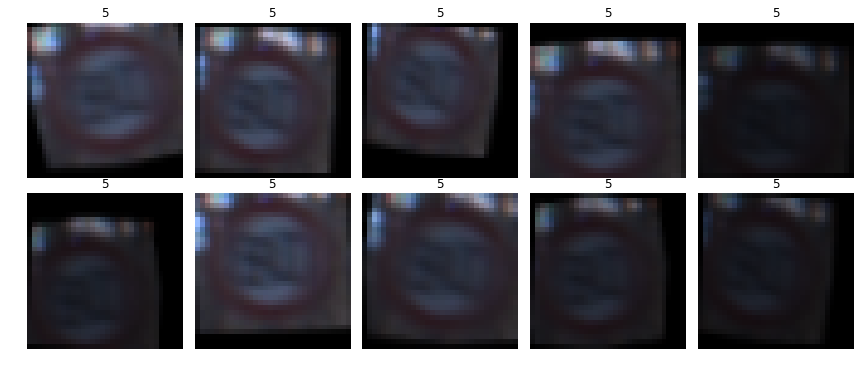

In [6]:
# show 10 images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = 0.1, wspace=0.01)
axs = axs.ravel()
index = random.randint(0, len(X_train))

image = X_train[index]
axs[i].axis('off')
axs[i].imshow(image)
axs[i].set_title(y_train[index])
    
for i in range(10):
    image = transform_image(X_train[index], 25, 2, 10.)
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

Now, all the images from each label are used to augment data uniformly i.e. if there are 10 images of label '4' and we need to create a total of 50 images then each of those images is used to create 4 new images and thus getting total 50.

In [7]:
total_labels_for_each = 3000

labels, counts = np.unique(y_train, return_counts=True)

temp_x = list(np.copy(X_train))
temp_y = list(np.copy(y_train))

new_x_train = []
new_y_train = []

new_pics_count_list = total_labels_for_each - counts
while np.sum(new_pics_count_list) > 0:
    i = 0
    while i < len(temp_x):
        if new_pics_count_list[temp_y[i]] > 0:
            new_x_train.append(transform_image(temp_x[i], 2, 0.1, 0.1))
            new_y_train.append(temp_y[i])
            new_pics_count_list[temp_y[i]] -= 1
            i += 1
        else:
            del temp_x[i]
            del temp_y[i]
#         print(np.sum(new_pics_count_list))

In [8]:
# appending augmented images
X_train = np.append(X_train, np.array(new_x_train), axis=0)
y_train = np.append(y_train, np.array(new_y_train))

What we can see now is that all the labels have equal frequency.

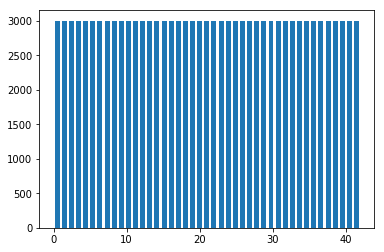

In [70]:
# histogram of label frequency
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

### Pre-process the Data Set

* the images are converted to grayscale to reduce the number of parameters and keeping the rgb values did not give any much gain.
* zero-centering is applied as we want the data to be centered at zero as variance of the center of data is not a relevant feature.
* normalisation is done since we are using a gradient based algorithm and any sort of variation is range is a problem.

In [71]:
def to_gray(a):
    a = np.swapaxes(a, 0, 3)
    a = np.average(a, axis=0)
    a = np.swapaxes([a], 0, 3)
    return a

def preprocess_images(x, mean, std):
    # convert to grayscale
    x = to_gray(x)
    # zero-center
    x -= np.mean(x, axis = 0)
    # normalize
    x /= np.std(x, axis = 0)

    return x

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = preprocess_images(X_train, mean, std)
print(X_train.shape)

X_valid = preprocess_images(X_valid, mean, std)
print(X_valid.shape)

X_test = preprocess_images(X_test, mean, std)
print(X_test.shape)

X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test = shuffle(X_test, y_test)

(129000, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [18]:
# setting up tensorflow
import tensorflow as tf

EPOCHS = 30
BATCH_SIZE = 512

### Model Architecture

Layer 1: Convolutional. Input = 32x32x1 Output = 30x30x10.

Layer 2: Convolutional. Input = 30x30x10 Output = 28x28x40.

Pooling: Input = 28x28x40 Output = 14x14x40.

Layer 3: Convolutional. Input = 14x14x40 Output = 12x12x100.

Pooling: Input = 12x12x100 Output = 6x6x100.

Layer 4: Convolutional. Input = 6x6x100 Output = 4x4x200.

Layer 5: Convolutional. Input = 4x4x200 Output = 1x1x400.

Flatten. Input = 1x1x400. Output = 400.

Layer 6: Fully Connected. Input = 400. Output = 120.

Layer 7: Fully Connected. Input = 120. Output = 84.

Layer 8: Fully Connected. Input = 84. Output = n_classes.

My final model results were:
* training set accuracy of 1.000
* validation set accuracy of 0.974
* test set accuracy of 0.954

An iterative approach was chosen:
* The first architecture was LeNet.
* Initially I was testing by adjusting some hyperparameters but it did not give any good results. Then I tested with augmenting data.
* Then I realised that basic LeNet could not really capture the information, I believe mainly because the convolution size was too large and layers too less.
* So, then I started tinkering with the architecture trying various sizes until I found a neat looking solution that produced decent results. (all the deicisions were made based of educated guesses on how the model is performing)
* Some reasons for choosing such an architecture
    * initially 2 convolutional layers to capture a lot of information as anyway the image size is 32 to a lot of information can be gathered with 4 and 3 size convolutions.
    * then pool conv pool, this is basically to quickly reduce the size while also looking for some higher level information and to help in reducing overfitting.
* I realised that in creating an interesting architecture I was also creating a lot of parameters in the neural net which inevitably led to overfitting. To tackle this I added highly aggressive dropout with keep_prob: 0.3.

In [69]:
from tensorflow.contrib.layers import flatten

input_depth = 1

def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([4,4,input_depth,10], mean=mu, stddev=sigma), name='wc1'),
        'wc2': tf.Variable(tf.truncated_normal([3,3,10,40], mean=mu, stddev=sigma), name='wc2'),
        'wc3': tf.Variable(tf.truncated_normal([3,3,40,100], mean=mu, stddev=sigma), name='wc3'),
        'wc4': tf.Variable(tf.truncated_normal([3,3,100,200], mean=mu, stddev=sigma), name='wc4'),
        'wc5': tf.Variable(tf.truncated_normal([3,3,200,400], mean=mu, stddev=sigma), name='wc5'),
        'wd1': tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma), name='wd1'),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma), name='wd2'),
        'out': tf.Variable(tf.truncated_normal([84, n_classes], mean=mu, stddev=sigma), name='out')
    }
    biases = {
        'bc1': tf.Variable(tf.zeros([10]), name='bc1'),
        'bc2': tf.Variable(tf.zeros([40]), name='bc2'),
        'bc3': tf.Variable(tf.zeros([100]), name='bc3'),
        'bc4': tf.Variable(tf.zeros([200]), name='bc4'),
        'bc5': tf.Variable(tf.zeros([400]), name='bc5'),
        'bd1': tf.Variable(tf.zeros([120]), name='bd1'),
        'bd2': tf.Variable(tf.zeros([84]), name='bd2'),
        'out': tf.Variable(tf.zeros([n_classes]), name='b_out')
    }
    
    # Layer 1: Convolutional. Input = 32x32x1 Output = 30x30x10.
    x = tf.nn.conv2d(x, weights['wc1'], strides=[1, 1, 1, 1], padding='VALID', name='convolution1')
    x = tf.nn.bias_add(x, biases['bc1'])

    # Activation.
    x = tf.nn.relu(x)

    # Layer 2: Convolutional. Input = 30x30x10 Output = 28x28x40.
    x = tf.nn.conv2d(x, weights['wc2'], strides=[1,1,1,1], padding='VALID', name='convolution2')
    x = tf.nn.bias_add(x, biases['bc2'])
    
    # Activation.
    x = tf.nn.relu(x)

    # Pooling: Input = 28x28x40 Output = 14x14x40.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool2')
    
    # Layer 3: Convolutional. Input = 14x14x40 Output = 12x12x100.
    x = tf.nn.conv2d(x, weights['wc3'], strides=[1,1,1,1], padding='VALID', name='convolution3')
    x = tf.nn.bias_add(x, biases['bc3'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling: Input = 12x12x100 Output = 6x6x100.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool2')
    
    # Layer 4: Convolutional. Input = 6x6x100 Output = 4x4x200.
    x = tf.nn.conv2d(x, weights['wc4'], strides=[1,1,1,1], padding='VALID', name='convolution4')
    x = tf.nn.bias_add(x, biases['bc4'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Layer 5: Convolutional. Input = 4x4x200 Output = 1x1x400.
    x = tf.nn.conv2d(x, weights['wc5'], strides=[1,1,1,1], padding='VALID', name='convolution5')
    x = tf.nn.bias_add(x, biases['bc5'])
    
    # Activation.
    x = tf.nn.relu(x)

    # Flatten. Input = 1x1x400. Output = 400.
    x = flatten(x)
    
    # Layer 6: Fully Connected. Input = 400. Output = 120.
    x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    x = tf.nn.dropout(x, keep_prob)

    # Layer 7: Fully Connected. Input = 120. Output = 84.
    x = tf.add(tf.matmul(x, weights['wd2']), biases['bd2'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    x = tf.nn.dropout(x, keep_prob)

    # Layer 8: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [39]:
x = tf.placeholder(tf.float32, (None, 32, 32, input_depth))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

## Training Pipeline

In [40]:
rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation

In [41]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [42]:
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
#             batch_x, batch_y = data.next()
#             print(len(batch_x), len(batch_y))
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.3})
            
        training_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './german_signs')
    print("Model saved")

Training...

EPOCH 1 ...
Training Accuracy = 0.501
Validation Accuracy = 0.382

EPOCH 2 ...
Training Accuracy = 0.848
Validation Accuracy = 0.725

EPOCH 3 ...
Training Accuracy = 0.938
Validation Accuracy = 0.871

EPOCH 4 ...
Training Accuracy = 0.945
Validation Accuracy = 0.896

EPOCH 5 ...
Training Accuracy = 0.976
Validation Accuracy = 0.924

EPOCH 6 ...
Training Accuracy = 0.985
Validation Accuracy = 0.927

EPOCH 7 ...
Training Accuracy = 0.990
Validation Accuracy = 0.955

EPOCH 8 ...
Training Accuracy = 0.994
Validation Accuracy = 0.948

EPOCH 9 ...
Training Accuracy = 0.995
Validation Accuracy = 0.953

EPOCH 10 ...
Training Accuracy = 0.997
Validation Accuracy = 0.960

EPOCH 11 ...
Training Accuracy = 0.998
Validation Accuracy = 0.961

EPOCH 12 ...
Training Accuracy = 0.998
Validation Accuracy = 0.957

EPOCH 13 ...
Training Accuracy = 0.998
Validation Accuracy = 0.967

EPOCH 14 ...
Training Accuracy = 0.999
Validation Accuracy = 0.963

EPOCH 15 ...
Training Accuracy = 0.999
Valid

### LOG
log was not starting at the begining of work.

* training: 0.960, validation: 0.889
    * batch size: 256, epochs: 40, rate: 0.001, mu: 0, sigma: 0.1, keep_prob: 0.5
    * Grayscale, Zero-center and normalisation of data is done
    
* training: 0.949, validation: 0.872
    * batch size: 256, epochs: 40, rate: 0.001, mu: 0, sigma: 0.1, keep_prob: 0.5
    * mean and std calculated only on training data
    
* training: 0.867, validation: 0.796
    * batch size: 256, epochs: 40, rate: 0.0002, mu: 0, sigma: 0.1, keep_prob: 0.5

* training: 0.925, validation: 0.861
    * batch size: 256, epochs: 70, rate: 0.0002, mu: 0, sigma: 0.1, keep_prob: 0.5
    
* training: 0.965, validation: 0.890
    * batch size: 256, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.5

* training: 0.972, validation: 0.899
    * batch size: 256, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.5
    * doubled the training data by randomly making transforms
    
* training: 0.990, validation: 0.903
    * batch size: 256, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.5
    * Added another convolutional layer
    
* training: 1.000, validation: 0.932
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.7
    
* training: 0.978, validation: 0.910
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.3

* training: 0.847, validation: 0.759
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.2
    
* training: 0.951, validation: 0.874
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.2
    * augmented data

* training: 1.000, validation: 0.927
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.2
    * all labels contain exactly 3000 samples (augmentation only for training data)
    
* training: 0.999, validation: 0.944
    * batch size: 512, epochs: 70, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.3
    * Modified convolution model
    
* training: 1.000, validation: 0.974
    * batch size: 512, epochs: 30, rate: 0.0005, mu: 0, sigma: 0.1, keep_prob: 0.3
    * Modified convolution model

## Results on test set

In [43]:
saver = tf.train.import_meta_graph('./german_signs.meta')
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./german_signs")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./german_signs
Test Set Accuracy = 0.954


---

## Step 3: Test a Model on New Images


### Load and Output the Images

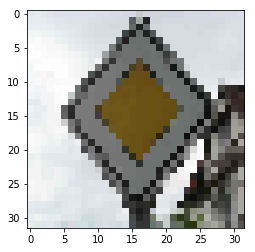

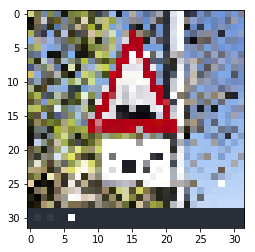

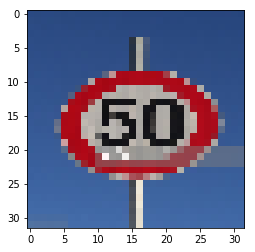

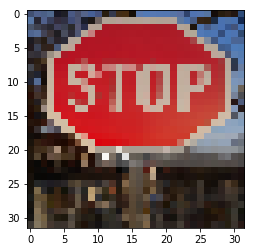

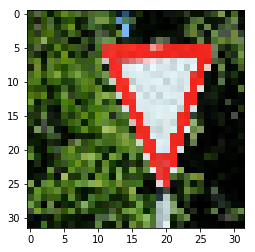

In [44]:
import os
import matplotlib.image as mpimg

ims = os.listdir("new_imgs/")
new_images = np.empty((0, 32, 32, 3))
for im in ims:
    image = mpimg.imread('new_imgs/'+im)
    image = cv2.resize(image, (32, 32))
    new_images = np.append(new_images, [image], axis=0)
    plt.figure()
    plt.imshow(image)
    
# giving the labels for the new images
new_images = to_gray(new_images)
new_labels = np.array([12, 71, 2, 14, 13])

It might be tricky to clasify the second image as it is very blurry.

### Predict the Sign Type for Each Image

In [48]:
# saver = tf.train.Saver()
saver = tf.train.import_meta_graph('./german_signs.meta')

results = []

with tf.Session() as sess:
    # Restore variables from disk.
    saver.restore(sess, "./german_signs")
    print("Model restored.")
    
    for i in range(len(new_images)):
        results.append(evaluate([new_images[i]], [new_labels[i]]))
    print(results)

INFO:tensorflow:Restoring parameters from ./german_signs
Model restored.
[1.0, 0.0, 1.0, 0.0, 1.0]


### Analyze Performance

In [49]:
accuracy = np.count_nonzero(np.array(results))*100/5
print(accuracy)

60.0


The accuracy obtained here is not really that good but considering that only 5 images were used and I tried to find images that would be tricky to classify I would say it performed decendly.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [54]:
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)
with tf.Session() as sess:
    saver.restore(sess, "./german_signs")
    top_5 = sess.run(top_k, feed_dict={x: new_images, keep_prob: 1.0})
    print(top_5)

INFO:tensorflow:Restoring parameters from ./german_signs
TopKV2(values=array([[  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.10577116e-16,   4.78587761e-31,
          3.82113651e-33,   2.00578248e-36],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]], dtype=float32), indices=array([[12,  0,  1,  2,  3],
       [10,  0,  1,  2,  3],
       [ 2,  0,  1,  3,  4],
       [40, 12, 11, 37, 41],
       [13,  0,  1,  2,  3]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry
sess = tf.Session()
saver.restore(sess, "./german_signs")
image_input = np.array([X_train[1]])
print(image_input.shape)
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap + 1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
my_tensor = sess.graph.get_tensor_by_name('convolution2:0')
outputFeatureMap(image_input, my_tensor)